In [4]:
from __future__ import division, print_function

import sys
import matplotlib
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
sys.path.append('../')
sys.path.append('../external/caffe-natural-language-object-retrieval/python/')
sys.path.append('../external/caffe-natural-language-object-retrieval/examples/coco_caption/')
import caffe

import util
from captioner import Captioner
import retriever
from glob import glob, iglob
from computeIOU import computeIOU
import xml.etree.ElementTree as ET

In [30]:
videos = sorted(glob('/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/*'))
video = videos[9].split('/')[-1]
print(video)
#video = 'Basketball'
start_frame = 1
if video == 'David':
    start_frame = 300
im_file = '/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/' + video + '/img/%04d.jpg' % (start_frame,)
edgebox_file = '../data/OTB50_edgeboxes_top500/' +  video + '.txt' # pre-extracted EdgeBox proposals
query_file = '../data/OTB50Entities/' + video + '.xml'

# First, select query
root = ET.parse( query_file ).getroot()
# querier = prettify( querier )
print(root[3][1].text)
query = root[3][1].text
#query = 'face of the man in yellow shirt'

# Second, gt box
gt_file = '/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/' + video + '/groundtruth_rect.txt'
try:
    gt_boxes = np.loadtxt(gt_file, delimiter=',').astype(int)
except ValueError:
    gt_boxes = np.loadtxt(gt_file, delimiter='\t').astype(int)
gt_box = gt_boxes[0, :]
gt_box[2] = gt_box[0] + gt_box[2] - 1;
gt_box[3] = gt_box[1] + gt_box[3] - 1;

pretrained_weights_path = '../models/scrc_full_vgg.caffemodel'
gpu_id = 0  # the GPU to test the SCRC model

David
the face of the man in yellow shirt


In [31]:
# Initialize the retrieval model
image_net_proto = '../prototxt/VGG_ILSVRC_16_layers_deploy.prototxt'
lstm_net_proto = '../prototxt/scrc_word_to_preds_full.prototxt'
vocab_file = '../data/vocabulary.txt'
# utilize the captioner module from LRCN
captioner = Captioner(pretrained_weights_path, image_net_proto, lstm_net_proto,
                      vocab_file, gpu_id)
captioner.set_image_batch_size(50)  # decrease the number if your GPU memory is small
vocab_dict = retriever.build_vocab_dict_from_captioner(captioner)

In [32]:
im = skimage.io.imread(im_file)
imsize = np.array([im.shape[1], im.shape[0]])  # [width, height]
candidate_boxes = np.loadtxt(edgebox_file).astype(int)

#print(candidate_boxes.shape)
#print(gt_box.shape)

# Third, find the best overlapped edgebox
overlaps = computeIOU(gt_box, candidate_boxes)
ovmax = np.max(overlaps)
jmax = np.argmax(overlaps)
bo_box = candidate_boxes[jmax, :]
print(ovmax)

0.699396509542


In [33]:
# Compute features
region_feature = retriever.compute_descriptors_edgebox(captioner, im,
                                                    candidate_boxes)
spatial_feature = retriever.compute_spatial_feat(candidate_boxes, imsize)
descriptors = np.concatenate((region_feature, spatial_feature), axis=1)
context_feature = captioner.compute_descriptors([im], output_name='fc7')

# Compute scores of each candidate region
scores = retriever.score_descriptors_context(descriptors, query,
                                             context_feature, captioner,
                                             vocab_dict)

# Retrieve the top-scoring candidate region given the query
retrieved_bbox = candidate_boxes[np.argmax(scores)]

Computing descriptors for images 0-0 of 1


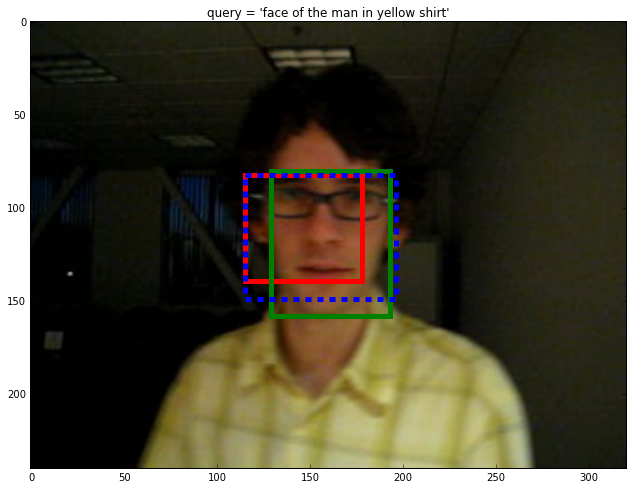

In [34]:
# Visualize the retrieval result
plt.figure(figsize=(12, 8))
plt.imshow(im)
ax = plt.gca()
x_min, y_min, x_max, y_max = retrieved_bbox
ax.add_patch(mpatches.Rectangle((x_min, y_min), x_max-x_min+1, y_max-y_min+1,
                                fill=False, edgecolor='r', linewidth=5))
ax.add_patch(mpatches.Rectangle((gt_box[0], gt_box[1]), gt_box[2]-gt_box[0]+1, gt_box[3]-gt_box[1]+1,
                                fill=False, edgecolor='g', linewidth=5))
ax.add_patch(mpatches.Rectangle((bo_box[0], bo_box[1]), bo_box[2]-bo_box[0]+1, bo_box[3]-bo_box[1]+1,
                                fill=False, edgecolor='b', linestyle='dashed',linewidth=5))
_ = plt.title("query = '%s'" % query)